<a href="https://colab.research.google.com/github/willdphan/amazon-forecast/blob/main/Amazon_Stock_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('/content/sample_data/AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [ ]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-5-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


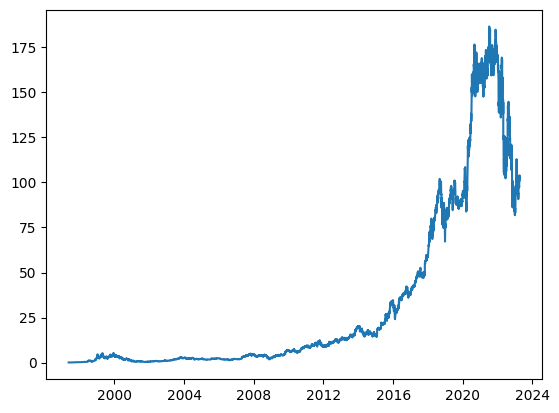

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [ ]:
from copy import deepcopy as dc

# prep dataframe with dataframe and lookback as params
def prepare_dataframe_for_lstm(df, n_steps):
    # make a copy of the df
    df = dc(df)
    # set the date as the index
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    # drpp values and edits directly on the copied df
    df.dropna(inplace=True)

    return df
# how many days to lookback
lookback = 7
# set variable for the prepared df function
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [ ]:
# convert df to numpy
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [ ]:
# get shifted df shape
shifted_df_as_np.shape

(6509, 8)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# set MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
# fit the df to the scaler and transform
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [ ]:
# set the X and y training cols
# 6509 rows, 7 columns
X = shifted_df_as_np[:, 1:]
# 6509 rows, 1 column
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [ ]:
# flip the column order
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [ ]:
# split the data to later label training and test set
split_index = int(len(X) * 0.95)

split_index

6183

In [ ]:
# label training and test sets
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [ ]:
# requirement for PyTorch LSTMs to have an extra dimension
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [ ]:
# convert to tensors and floats
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [ ]:
from torch.utils.data import Dataset
# make custom dataset class
class TimeSeriesDataset(Dataset):
    # takes in matrix x and output vector y stored in self
    def __init__(self, X, y):
        self.X = X
        self.y = y
    # get the length
    def __len__(self):
        return len(self.X)
    # gets the x and y of the index
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# pass in the training and testing dataset into TimeSeries Dataset
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
train_dataset

In [ ]:
# wrap the datasets in DataLoaders to get our batches
from torch.utils.data import DataLoader

# set batch size of 16
batch_size = 16

# shuffle the training loader, not the test loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# for visual, looping over train_loader every batch to get batch size
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
# LSTM NN model
class LSTM(nn.Module):
    # takes in input (number of features, 1), hidden size, and stacked layers (stack LSTMs)
    # init defines layers
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        # store params in self
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        # LSTM model with params, returns batch as first dimension
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        # fully connected layers maps from hidden_size to 1
        self.fc = nn.Linear(hidden_size, 1)

    # forward passes data through layers
    def forward(self, x):
        # dynamically get size from import
        batch_size = x.size(0)
        # initiallize LSTM with h0, c0 with particular shape and the device
        # they're working on
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # pass h0 and c0 into the tuple below for the output
        out, _ = self.lstm(x, (h0, c0))
        # get the actual output from passing in through the fc layer
        out = self.fc(out[:, -1, :])
        return out

# pass in params
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    # set model to training mode
    model.train(True)
    # print epoch number
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    # look over train_loader
    for batch_index, batch in enumerate(train_loader):
        # put batch on the device
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        # get output from the model by putting batch into model
        output = model(x_batch)
        # comparing model output to the untested ground truth
        loss = loss_function(output, y_batch)
        # gets the accumulated loss value
        running_loss += loss.item()

        # reset gradients
        optimizer.zero_grad()
        # backward pass through the loss to calc gradient
        loss.backward()
        # make model better with step
        optimizer.step()

        # every 100 batches get average loss and print the average loss across batches
        # then reset the accumulated loss to 0
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
# same thing as above, but with no gradients and optimizer
def validate_one_epoch():
    # put in eval mode
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
# training loop for the functions above
# set Learning Rate and Optimizer
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loop to train 1 epoch and validate 1 epoch
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.724
Batch 200, Loss: 0.133
Batch 300, Loss: 0.047

Val Loss: 0.032
***************************************************

Epoch: 2
Batch 100, Loss: 0.010
Batch 200, Loss: 0.008
Batch 300, Loss: 0.007

Val Loss: 0.019
***************************************************

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Batch 300, Loss: 0.005

Val Loss: 0.012
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.010
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
*****************

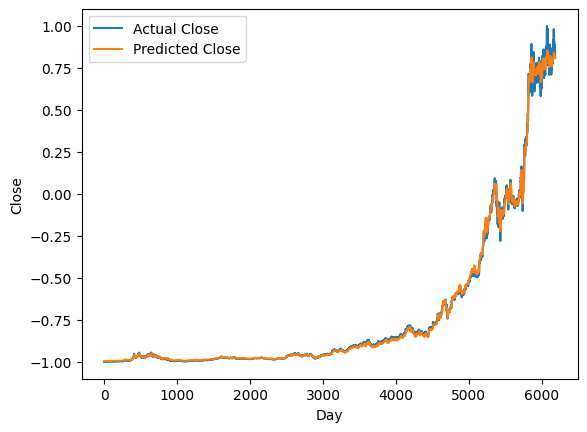

In [ ]:
# look at model with no gradients for predictions
with torch.no_grad():
    # has to be on cpu because of numpy, numpy doesn't use gpu
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
# we need to get actual X_train numbers back
train_predictions = predicted.flatten()

# inverse transform the first column
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# get the first column, early numbers should be small, later numbers should be large
train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.51986265,   0.5192846 ,   0.51872879, ..., 169.17916223,
       168.97677429, 168.98005914])

In [ ]:
# repeat for y_train data
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

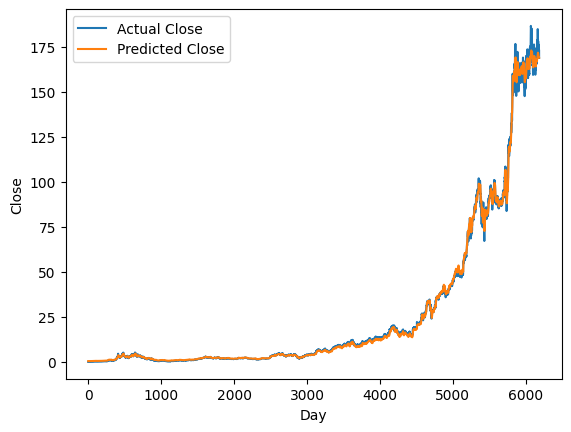

In [ ]:
# now graph is in proper scale (x any y axis numbers)
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
# do the same thing above to X_test data. .detch() is an alt to remove grads
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([168.77439747, 168.33424415, 167.96545712, 167.75639944,
       167.94094024, 168.09643429, 167.94211856, 167.99202495,
       167.97360533, 167.97928017, 167.71501365, 167.59787621,
       167.51522136, 167.08620651, 166.46017844, 165.91087469,
       165.33973308, 165.20904493, 165.02592701, 164.58851384,
       164.28712461, 163.89109167, 163.17537772, 162.03605142,
       159.37050898, 156.77689422, 154.04976778, 150.87212767,
       148.23463709, 146.81204104, 147.09964056, 148.71872181,
       149.79656972, 149.18870559, 151.86740966, 154.7138023 ,
       157.01312556, 158.53994753, 159.42277757, 159.53518505,
       160.72392307, 160.60557951, 160.68004724, 160.07810807,
       159.09459819, 158.01064747, 156.7034603 , 156.15769152,
       156.1181288 , 155.82712214, 155.45512808, 155.37103924,
       154.98650605, 154.72681387, 152.44607697, 149.54734904,
       147.50429415, 147.35704836, 146.85696735, 145.99259584,
       146.47526325, 149.09534579, 152.32292008, 155.38

In [ ]:
# get the ground truth for y_test data
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

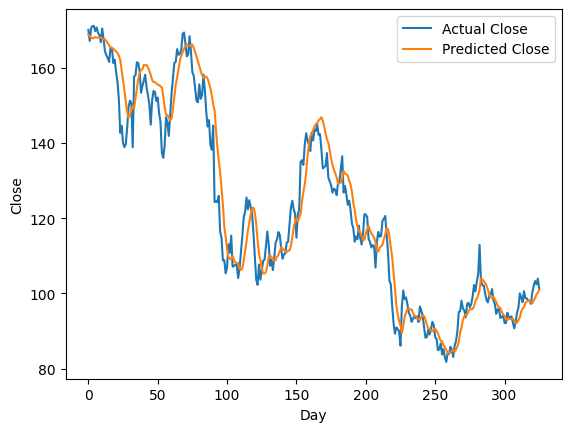

In [ ]:
# evaluates model to the ground truth y_test
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()